<a href="https://colab.research.google.com/github/gabriel-masson/Chika_2025.1/blob/main/PAHO_Dores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

#-

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/_MESTRADO/REPLICK/Base de Dados/V2_BANCO_DOTLAB_347.xlsx')
df.head()

,PID,D0_Diagnóstico CHIKV,D0_Método diagnóstico,D0_Data de início dos sintomas,D0_Data de recrutamento,D0_Fase CHIKF (D0),D0_DPIS ambulat-D0,D0_Dias após inicio de sintomas (DPIS)- recrut,D0_Novo critério (0-3/4-10),D0_Critério anterior (0/1-10),...,D0_intensdor_dedomaod,D0_intensdor_quadrile,D0_intensdor_quadrild,D0_intensdor_joelhoe,D0_intensdor_joelhod,D0_intensdor_tornozeloe,D0_intensdor_tornozelod,D0_intensdor_dedopee,D0_intensdor_dedoped,D0_categoria_ativdoenca
0,REC001,Positivo,TR,2019-08-01,2019-09-09,Subagudo,28,39,1,1,...,4,1,1,3,3,4,4,3,2,3
1,REC002,Positivo,TR,2019-09-01,2019-09-16,Subagudo,10,15,1,1,...,4,4,4,4,4,4,4,1,1,2
2,REC004,Positivo,RT-qPCR (ZDC),2020-07-04,2020-07-08,Agudo,4,4,1,1,...,4,1,1,1,1,1,1,1,1,4
3,REC005,Positivo,TR,2020-05-26,2020-07-08,Subagudo,43,43,1,1,...,3,2,2,2,2,4,4,3,3,4
4,REC006,Positivo,TR,2020-06-19,2020-07-13,Subagudo,24,24,1,1,...,2,1,1,1,1,2,2,3,2,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Columns: 252 entries, PID to D0_categoria_ativdoenca
dtypes: datetime64[ns](4), float64(12), int64(227), object(9)
memory usage: 683.3+ KB


##Utils

In [ ]:
def avaliation_model(y_test,y_pred):
  metricas = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=1)).round(4).T.drop('support', axis=1)
  metricas.drop(['macro avg', 'weighted avg'], axis=0, inplace=True)
  auc = roc_auc_score(y_test, y_pred)

  accuracy= (metricas.loc["accuracy", "f1-score"]*100).round(6)
  recall= (metricas.loc["1", "recall"]*100).round(6)
  especificity= (metricas.loc["0", "recall"]*100).round(6)
  precision= (metricas.loc["1", "precision"]*100).round(6)
  f1_score= (metricas.loc["1", "f1-score"]*100).round(6)
  AUC= (auc*100).round(2)
  print(f'Accuracy: {accuracy}')
  print(f'Recall: {recall}')
  print(f'Rspecificity: {especificity}')
  print(f'Precision: {precision}')
  print(f'F1_score: {f1_score}')
  print(f'AUC: {AUC}')


In [ ]:
#average = (qte_class_positive + qte_class_negative)/2
average = 173
def train_avaliation_model(df_train, model, scenery = " "):
  print("=*="*4)
  print(scenery)

  X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)
  y = df_train['D0_Novo critério (0-3/4-10)']

  X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)

  y = df_train['D0_Novo critério (0-3/4-10)'].astype(int)

  under_sampler = RandomUnderSampler(sampling_strategy={1: average}, random_state=42)
  over_sampler = RandomOverSampler(sampling_strategy={0: average}, random_state=42)

  X_resampled, y_resampled = under_sampler.fit_resample(X, y)
  X_resampled, y_resampled = over_sampler.fit_resample(X_resampled, y_resampled)

  X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  avaliation_model(y_test,y_pred)


In [ ]:
def cross_val_models_f1(df_train, model):

    X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)
    y = df_train['D0_Novo critério (0-3/4-10)'].astype(int)

    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    f1_scorer = make_scorer(f1_score, average='weighted')

    cross_model = cross_validate(model, X, y, cv=kf, scoring=f1_scorer)
    return cross_model['test_score']

In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth= 79, max_features='log2', min_samples_leaf= 9, min_samples_split= 7, random_state=42)
rf_model = RandomForestClassifier(criterion= 'gini', n_estimators= 974, max_depth= 1000, min_samples_split= 0.01, min_samples_leaf= 0.01, random_state=42)
svm_model = SVC(kernel= 'linear', degree= 2, gamma= 4.2594025, C= 0.010007202, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, colsample_bytree= 0.239900212, learning_rate= 0.068163796, max_depth= 780, n_estimators= 699, subsample= 0.067780561)
ada_model = AdaBoostClassifier(n_estimators= 502, learning_rate= 0.2607703, algorithm= "SAMME", random_state=42)
gb_model = GradientBoostingClassifier(n_estimators= 288, learning_rate= 0.0182112977748381, max_depth= 999,min_samples_split= 0.01, min_samples_leaf= 0.403862979577575,)
models = [dt_model, rf_model, svm_model, xgb_model, ada_model, gb_model]

##Teste sem PAHO

In [ ]:
df.columns

Index(['PID', 'D0_Diagnóstico CHIKV', 'D0_Método diagnóstico',
       'D0_Data de início dos sintomas', 'D0_Data de recrutamento',
       'D0_Fase CHIKF (D0)', 'D0_DPIS ambulat-D0',
       'D0_Dias após inicio de sintomas (DPIS)- recrut',
       'D0_Novo critério (0-3/4-10)', 'D0_Critério anterior (0/1-10)',
       ...
       'D0_intensdor_dedomaod', 'D0_intensdor_quadrile',
       'D0_intensdor_quadrild', 'D0_intensdor_joelhoe', 'D0_intensdor_joelhod',
       'D0_intensdor_tornozeloe', 'D0_intensdor_tornozelod',
       'D0_intensdor_dedopee', 'D0_intensdor_dedoped',
       'D0_categoria_ativdoenca'],
      dtype='object', length=252)

In [ ]:
#features extracted according to the GUIDE FOR CLINICAL DIAGNOSIS AND TREATMENT OF DENGUE, CHIKUNGUNYA AND ZIKA by PAHO

features = [ 'D0_idade', 'D0_genero', 'D0_cor',

            'D0_febre_episodio1',         'D0_cefaleia_episodio1',          'D0_fadiga_episodio1',
             'D0_palidez_episodio1',     'D0_hiperemia_episodio1',          'D0_turvacao_episodio1',
             'D0_nausea_episodio1',      'D0_vomito_episodio1',             'D0_diarreia_episodio1',
             'D0_parestesia_episodio1',  'D0_disestesia_episodio1',         'D0_artralgia_episodio1',
             'D0_edema_episodio1',       'D0_mialgia_episodio1',            'D0_lombalgia_episodio1',
             'D0_prurido_episodio1',     'D0_rash_episodio1',               'D0_lesoes_episodio1',
             'D0_alopecia_episodio1',    'D0_alteracaomemoria_episodio1',   'D0_alteracaolibido_episodio1',
             'D0_enpp_fadiga',

             'D0_intensdor_ombrod',
             'D0_intensdor_ombroe',
             'D0_intensdor_punhoe',
             'D0_intensdor_punhod',
             'D0_intensdor_dedomaoe',
             'D0_intensdor_dedomaod',
             'D0_intensdor_joelhoe',
             'D0_intensdor_joelhod',
             'D0_intensdor_tornozeloe',
             'D0_intensdor_tornozelod',
             'D0_intensdor_dedopee',
             'D0_intensdor_dedoped',
             'D0_Novo critério (0-3/4-10)',
    #              'D0_intensdor_pesco_o',
    # 'D0_intensdor_costas',
    # 'D0_intensdor_ombroe',
    # 'D0_intensdor_ombrod',
    # 'D0_intensdor_cotoveloe',
    # 'D0_intensdor_cotovelod',
    # 'D0_intensdor_punhoe',
    # 'D0_intensdor_punhod',
    # 'D0_intensdor_dedomaoe',
    # 'D0_intensdor_dedomaod',
    # 'D0_intensdor_quadrile',
    # 'D0_intensdor_quadrild',
    # 'D0_intensdor_joelhoe',
    # 'D0_intensdor_joelhod',
    # 'D0_intensdor_tornozeloe',
    # 'D0_intensdor_tornozelod',
    # 'D0_intensdor_dedopee',
    # 'D0_intensdor_dedoped',

            'D0_Dias após inicio de sintomas (DPIS)- recrut', 'D0_DPIS ambulat-D0',
]


df = df[features]

'D0_Dias após inicio de sintomas (DPIS)- recrut' == 'D0_Data de início dos sintomas' - 'D0_Data de recrutamento'

In [ ]:
df.head()

,D0_idade,D0_genero,D0_cor,D0_febre_episodio1,D0_cefaleia_episodio1,D0_fadiga_episodio1,D0_palidez_episodio1,D0_hiperemia_episodio1,D0_turvacao_episodio1,D0_nausea_episodio1,...,D0_prurido_episodio1,D0_rash_episodio1,D0_lesoes_episodio1,D0_alopecia_episodio1,D0_alteracaomemoria_episodio1,D0_alteracaolibido_episodio1,D0_enpp_fadiga,D0_Novo critério (0-3/4-10),D0_Dias após inicio de sintomas (DPIS)- recrut,D0_DPIS ambulat-D0
0,34,2,3,1,0,1,0,0,0,0,...,0,1,0,0,0,0,7,1,39,28
1,67,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,5,1,15,10
2,48,2,1,1,0,1,0,1,0,0,...,1,1,1,0,0,0,0,1,4,4
3,47,2,1,1,1,1,0,0,0,0,...,0,1,0,1,0,1,5,1,43,43
4,23,2,3,1,0,1,0,0,0,0,...,1,1,0,0,0,0,3,1,24,24


In [ ]:
fs_high = ['D0_artralgia_episodio1']
fs_mid = ['D0_mialgia_episodio1','D0_lesoes_episodio1']
fs_low = ['D0_febre_episodio1',       'D0_cefaleia_episodio1',   'D0_fadiga_episodio1',
     'D0_palidez_episodio1',     'D0_hiperemia_episodio1',  'D0_turvacao_episodio1',
     'D0_nausea_episodio1',      'D0_vomito_episodio1',     'D0_diarreia_episodio1',
     'D0_parestesia_episodio1',  'D0_disestesia_episodio1', 'D0_edema_episodio1',
     'D0_lombalgia_episodio1',   'D0_prurido_episodio1',    'D0_rash_episodio1',
     'D0_alopecia_episodio1',    'D0_alteracaomemoria_episodio1',   'D0_alteracaolibido_episodio1',
     'D0_enpp_fadiga', ]

# fs_dores = [           'D0_intensdor_ombroe',
#              'D0_intensdor_ombrod',
#              'D0_intensdor_punhoe',
#              'D0_intensdor_punhod',
#              'D0_intensdor_dedomaoe',
#              'D0_intensdor_dedomaod',
#              'D0_intensdor_joelhoe',
#              'D0_intensdor_joelhod',
#              'D0_intensdor_tornozeloe',
#              'D0_intensdor_tornozelod',
#              'D0_intensdor_dedopee',
#              'D0_intensdor_dedoped',]
fs_dores = ['D0_Novo critério (0-3/4-10)',
                 'D0_intensdor_pesco_o',
    'D0_intensdor_costas',
    'D0_intensdor_ombroe',
    'D0_intensdor_ombrod',
    'D0_intensdor_cotoveloe',
    'D0_intensdor_cotovelod',
    'D0_intensdor_punhoe',
    'D0_intensdor_punhod',
    'D0_intensdor_dedomaoe',
    'D0_intensdor_dedomaod',
    'D0_intensdor_quadrile',
    'D0_intensdor_quadrild',
    'D0_intensdor_joelhoe',
    'D0_intensdor_joelhod',
    'D0_intensdor_tornozeloe',
    'D0_intensdor_tornozelod',
    'D0_intensdor_dedopee',
    'D0_intensdor_dedoped',]

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

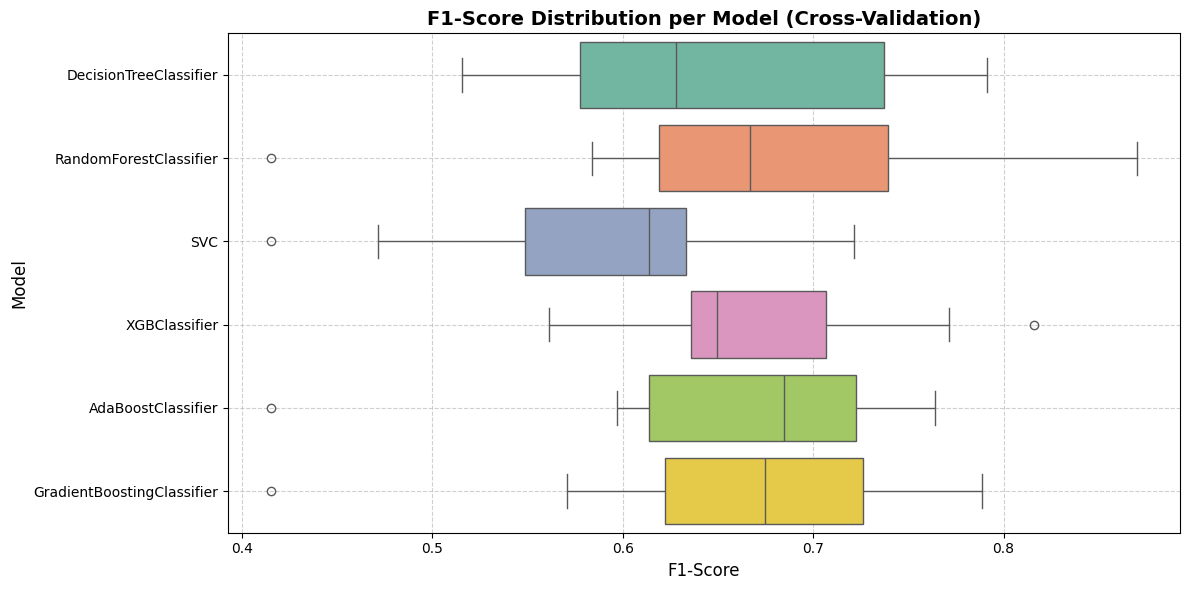

In [ ]:
models = {
    "DecisionTreeClassifier":  DecisionTreeClassifier(criterion='entropy', max_depth= 79, max_features='log2', min_samples_leaf= 9, min_samples_split= 7, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(criterion= 'gini', n_estimators= 974, max_depth= 1000, min_samples_split= 0.01, min_samples_leaf= 0.01, random_state=42),
    "SVC": SVC(kernel= 'linear', degree= 2, gamma= 4.2594025, C= 0.010007202, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(random_state=42, colsample_bytree= 0.239900212, learning_rate= 0.068163796, max_depth= 780, n_estimators= 699, subsample= 0.067780561),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators= 502, learning_rate= 0.2607703, algorithm= "SAMME", random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators= 288, learning_rate= 0.0182112977748381, max_depth= 999,min_samples_split= 0.01, min_samples_leaf= 0.403862979577575,)
}

# Load and prepare the df_train DataFrame here...

# Store F1-score results for each model
f1_scores = {}
for model_name, model in models.items():
    f1_scores[model_name] = cross_val_models_f1(df, model)

# Convert to DataFrame for ease of use with seaborn
f1_df = pd.DataFrame([
    {'Model': model_name, 'F1 Score': score}
    for model_name, scores in f1_scores.items()
    for score in scores
])

# Plot with seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=f1_df, y='Model', x='F1 Score', palette='Set2')
plt.title('F1-Score Distribution per Model (Cross-Validation)', fontsize=14, fontweight='bold')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
for model_name, model in models.items(): # Iterate through key-value pairs
  train_avaliation_model(df, model, model_name) # Use model_name instead of model.__class__.__name__

=*==*==*==*=
DecisionTreeClassifier
Accuracy: 63.46
Recall: 64.15
Rspecificity: 62.75
Precision: 64.15
F1_score: 64.15
AUC: 63.45
=*==*==*==*=
RandomForestClassifier
Accuracy: 71.15
Recall: 69.81
Rspecificity: 72.55
Precision: 72.55
F1_score: 71.15
AUC: 71.18
=*==*==*==*=
SVC
Accuracy: 54.81
Recall: 62.26
Rspecificity: 47.06
Precision: 55.0
F1_score: 58.41
AUC: 54.66
=*==*==*==*=
XGBClassifier
Accuracy: 63.46
Recall: 49.06
Rspecificity: 78.43
Precision: 70.27
F1_score: 57.78
AUC: 63.74
=*==*==*==*=
AdaBoostClassifier


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy: 64.42
Recall: 60.38
Rspecificity: 68.63
Precision: 66.67
F1_score: 63.37
AUC: 64.5
=*==*==*==*=
GradientBoostingClassifier
Accuracy: 63.46
Recall: 54.72
Rspecificity: 72.55
Precision: 67.44
F1_score: 60.42
AUC: 63.63


#Ajustando os pesos

In [ ]:
df.columns

Index(['D0_idade', 'D0_genero', 'D0_cor', 'D0_febre_episodio1',
       'D0_cefaleia_episodio1', 'D0_fadiga_episodio1', 'D0_palidez_episodio1',
       'D0_hiperemia_episodio1', 'D0_turvacao_episodio1',
       'D0_nausea_episodio1', 'D0_vomito_episodio1', 'D0_diarreia_episodio1',
       'D0_parestesia_episodio1', 'D0_disestesia_episodio1',
       'D0_artralgia_episodio1', 'D0_edema_episodio1', 'D0_mialgia_episodio1',
       'D0_lombalgia_episodio1', 'D0_prurido_episodio1', 'D0_rash_episodio1',
       'D0_lesoes_episodio1', 'D0_alopecia_episodio1',
       'D0_alteracaomemoria_episodio1', 'D0_alteracaolibido_episodio1',
       'D0_enpp_fadiga', 'D0_Novo critério (0-3/4-10)', 'D0_intensdor_pesco_o',
       'D0_intensdor_costas', 'D0_intensdor_ombroe', 'D0_intensdor_ombrod',
       'D0_intensdor_cotoveloe', 'D0_intensdor_cotovelod',
       'D0_intensdor_punhoe', 'D0_intensdor_punhod', 'D0_intensdor_dedomaoe',
       'D0_intensdor_dedomaod', 'D0_intensdor_quadrile',
       'D0_intensdor_quadr

####Calculating the weights

In [ ]:
def calc_weight(x0, x1, x, y0, y1):

  intervalo = x1 - x0
  w = (y1-y0)
  intervalo = intervalo * w
  tempo_total = x - x0  #Ajustar para |x - x0|
  y = y0 + (intervalo/tempo_total)
  return y




In [ ]:
x1 = df['D0_DPIS ambulat-D0'] #Days after onset of symptoms in which the individual made an outpatient appointment
x0 = df['D0_Dias após inicio de sintomas (DPIS)- recrut']  #Days after onset of symptoms in which the individual was recruited and the sample was collected

In [ ]:
for col in fs_high:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.76, y1= 1)
for col in fs_mid:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.51, y1= 0.75)

for col in fs_low:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.25, y1= 0.5)

In [ ]:
df.columns

Index(['D0_idade', 'D0_genero', 'D0_cor', 'D0_febre_episodio1',
       'D0_cefaleia_episodio1', 'D0_fadiga_episodio1', 'D0_palidez_episodio1',
       'D0_hiperemia_episodio1', 'D0_turvacao_episodio1',
       'D0_nausea_episodio1', 'D0_vomito_episodio1', 'D0_diarreia_episodio1',
       'D0_parestesia_episodio1', 'D0_disestesia_episodio1',
       'D0_artralgia_episodio1', 'D0_edema_episodio1', 'D0_mialgia_episodio1',
       'D0_lombalgia_episodio1', 'D0_prurido_episodio1', 'D0_rash_episodio1',
       'D0_lesoes_episodio1', 'D0_alopecia_episodio1',
       'D0_alteracaomemoria_episodio1', 'D0_alteracaolibido_episodio1',
       'D0_enpp_fadiga', 'D0_Novo critério (0-3/4-10)',
       'D0_Dias após inicio de sintomas (DPIS)- recrut', 'D0_DPIS ambulat-D0'],
      dtype='object')

In [ ]:
df = df.drop(['D0_Dias após inicio de sintomas (DPIS)- recrut', 'D0_DPIS ambulat-D0'], axis=1)

#Testando modelos

##pré-processamento

##Visualização

In [ ]:
models = {
    "DecisionTreeClassifier":  DecisionTreeClassifier(criterion='entropy', max_depth= 79, max_features='log2', min_samples_leaf= 9, min_samples_split= 7, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(criterion= 'gini', n_estimators= 974, max_depth= 1000, min_samples_split= 0.01, min_samples_leaf= 0.01, random_state=42),
    "SVC": SVC(kernel= 'linear', degree= 2, gamma= 4.2594025, C= 0.010007202, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(random_state=42, colsample_bytree= 0.239900212, learning_rate= 0.068163796, max_depth= 780, n_estimators= 699, subsample= 0.067780561),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators= 502, learning_rate= 0.2607703, algorithm= "SAMME", random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators= 288, learning_rate= 0.0182112977748381, max_depth= 999,min_samples_split= 0.01, min_samples_leaf= 0.403862979577575,)
}

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

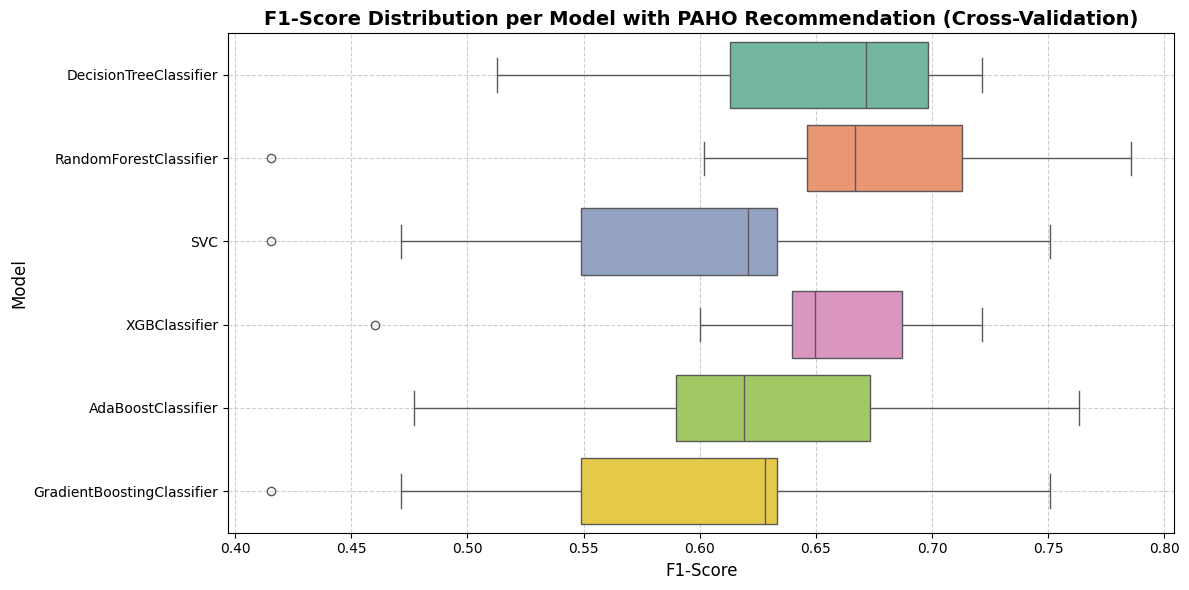

In [ ]:
# Load and prepare the df_train DataFrame here...

# Store F1-score results for each model
f1_scores = {}
for model_name, model in models.items():
    f1_scores[model_name] = cross_val_models_f1(df, model)

# Convert to DataFrame for ease of use with seaborn
f1_df = pd.DataFrame([
    {'Model': model_name, 'F1 Score': score}
    for model_name, scores in f1_scores.items()
    for score in scores
])

# Plot with seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=f1_df, y='Model', x='F1 Score', palette='Set2')
plt.title('F1-Score Distribution per Model with PAHO Recommendation (Cross-Validation)', fontsize=14, fontweight='bold')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
for model_name, model in models.items(): # Iterate through key-value pairs
  train_avaliation_model(df, model, model_name) # Use model_name instead of model.__class__.__name__

=*==*==*==*=
DecisionTreeClassifier
Accuracy: 63.46
Recall: 64.15
Rspecificity: 62.75
Precision: 64.15
F1_score: 64.15
AUC: 63.45
=*==*==*==*=
RandomForestClassifier
Accuracy: 71.15
Recall: 69.81
Rspecificity: 72.55
Precision: 72.55
F1_score: 71.15
AUC: 71.18
=*==*==*==*=
SVC
Accuracy: 54.81
Recall: 62.26
Rspecificity: 47.06
Precision: 55.0
F1_score: 58.41
AUC: 54.66
=*==*==*==*=
XGBClassifier
Accuracy: 63.46
Recall: 49.06
Rspecificity: 78.43
Precision: 70.27
F1_score: 57.78
AUC: 63.74
=*==*==*==*=
AdaBoostClassifier


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy: 64.42
Recall: 60.38
Rspecificity: 68.63
Precision: 66.67
F1_score: 63.37
AUC: 64.5
=*==*==*==*=
GradientBoostingClassifier
Accuracy: 63.46
Recall: 54.72
Rspecificity: 72.55
Precision: 67.44
F1_score: 60.42
AUC: 63.63


In [ ]:
fs_high = ['D0_artralgia_episodio1',      'D0_intensdor_tornozeloe', 'D0_intensdor_tornozelod',  ]
fs_mid = ['D0_mialgia_episodio1','D0_lesoes_episodio1',     'D0_intensdor_punhoe',
    'D0_intensdor_punhod',    'D0_intensdor_dedomaod',    'D0_intensdor_dedopee',    'D0_intensdor_dedoped',]
fs_low = ['D0_febre_episodio1',       'D0_cefaleia_episodio1',   'D0_fadiga_episodio1', 'D0_intensdor_joelhoe',
     'D0_palidez_episodio1',     'D0_hiperemia_episodio1',  'D0_turvacao_episodio1',
     'D0_nausea_episodio1',      'D0_vomito_episodio1',     'D0_diarreia_episodio1',
     'D0_parestesia_episodio1',  'D0_disestesia_episodio1', 'D0_edema_episodio1',
     'D0_lombalgia_episodio1',   'D0_prurido_episodio1',    'D0_rash_episodio1',
     'D0_alopecia_episodio1',    'D0_alteracaomemoria_episodio1',   'D0_alteracaolibido_episodio1',
     'D0_enpp_fadiga','D0_intensdor_joelhod', 'D0_intensdor_ombroe',
    'D0_intensdor_ombrod', 'D0_intensdor_dedomaoe',
  'D0_intensdor_dedopee',  'D0_intensdor_dedoped',
]
#Com todos os pontos de dores
# fs_high = ['D0_artralgia_episodio1',      'D0_intensdor_tornozeloe', 'D0_intensdor_tornozelod',  ]
# fs_mid = ['D0_mialgia_episodio1','D0_lesoes_episodio1',     'D0_intensdor_punhoe',
#     'D0_intensdor_punhod',    'D0_intensdor_dedomaod',    'D0_intensdor_dedopee',    'D0_intensdor_dedoped',]
# fs_low = ['D0_febre_episodio1',       'D0_cefaleia_episodio1',   'D0_fadiga_episodio1', 'D0_intensdor_joelhoe',
#      'D0_palidez_episodio1',     'D0_hiperemia_episodio1',  'D0_turvacao_episodio1',
#      'D0_nausea_episodio1',      'D0_vomito_episodio1',     'D0_diarreia_episodio1',
#      'D0_parestesia_episodio1',  'D0_disestesia_episodio1', 'D0_edema_episodio1',
#      'D0_lombalgia_episodio1',   'D0_prurido_episodio1',    'D0_rash_episodio1',
#      'D0_alopecia_episodio1',    'D0_alteracaomemoria_episodio1',   'D0_alteracaolibido_episodio1',
#      'D0_enpp_fadiga','D0_intensdor_joelhod', 'D0_intensdor_pesco_o', 'D0_intensdor_costas', 'D0_intensdor_ombroe',
#     'D0_intensdor_ombrod', 'D0_intensdor_cotoveloe', 'D0_intensdor_cotovelod', 'D0_intensdor_dedomaoe',
#     'D0_intensdor_quadrile', 'D0_intensdor_quadrild',  'D0_intensdor_dedopee',  'D0_intensdor_dedoped',
# ]

In [ ]:
df.columns

Index(['D0_idade', 'D0_genero', 'D0_cor', 'D0_febre_episodio1',
       'D0_cefaleia_episodio1', 'D0_fadiga_episodio1', 'D0_palidez_episodio1',
       'D0_hiperemia_episodio1', 'D0_turvacao_episodio1',
       'D0_nausea_episodio1', 'D0_vomito_episodio1', 'D0_diarreia_episodio1',
       'D0_parestesia_episodio1', 'D0_disestesia_episodio1',
       'D0_artralgia_episodio1', 'D0_edema_episodio1', 'D0_mialgia_episodio1',
       'D0_lombalgia_episodio1', 'D0_prurido_episodio1', 'D0_rash_episodio1',
       'D0_lesoes_episodio1', 'D0_alopecia_episodio1',
       'D0_alteracaomemoria_episodio1', 'D0_alteracaolibido_episodio1',
       'D0_enpp_fadiga', 'D0_intensdor_ombrod', 'D0_intensdor_ombroe',
       'D0_intensdor_punhoe', 'D0_intensdor_punhod', 'D0_intensdor_dedomaoe',
       'D0_intensdor_dedomaod', 'D0_intensdor_joelhoe', 'D0_intensdor_joelhod',
       'D0_intensdor_tornozeloe', 'D0_intensdor_tornozelod',
       'D0_intensdor_dedopee', 'D0_intensdor_dedoped',
       'D0_Novo critério (0-3/4

In [ ]:
for col in fs_high:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.66, y1= 1)
for col in fs_mid:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.34, y1= 0.65)

for col in fs_low:
  df[col] = calc_weight(x0 =x0, x1 = x1, x = 90, y0 = 0.0, y1= 0.33)

In [ ]:
for model_name, model in models.items(): # Iterate through key-value pairs
  train_avaliation_model(df, model, model_name) # Use model_name instead of model.__class__.__name__

=*==*==*==*=
DecisionTreeClassifier
Accuracy: 57.69
Recall: 71.7
Rspecificity: 43.14
Precision: 56.72
F1_score: 63.33
AUC: 57.42
=*==*==*==*=
RandomForestClassifier
Accuracy: 62.5
Recall: 60.38
Rspecificity: 64.71
Precision: 64.0
F1_score: 62.14
AUC: 62.54
=*==*==*==*=
SVC
Accuracy: 55.77
Recall: 69.81
Rspecificity: 41.18
Precision: 55.22
F1_score: 61.67
AUC: 55.49
=*==*==*==*=
XGBClassifier
Accuracy: 59.62
Recall: 62.26
Rspecificity: 56.86
Precision: 60.0
F1_score: 61.11
AUC: 59.56
=*==*==*==*=
AdaBoostClassifier


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy: 59.62
Recall: 60.38
Rspecificity: 58.82
Precision: 60.38
F1_score: 60.38
AUC: 59.6
=*==*==*==*=
GradientBoostingClassifier
Accuracy: 52.88
Recall: 45.28
Rspecificity: 60.78
Precision: 54.55
F1_score: 49.48
AUC: 53.03


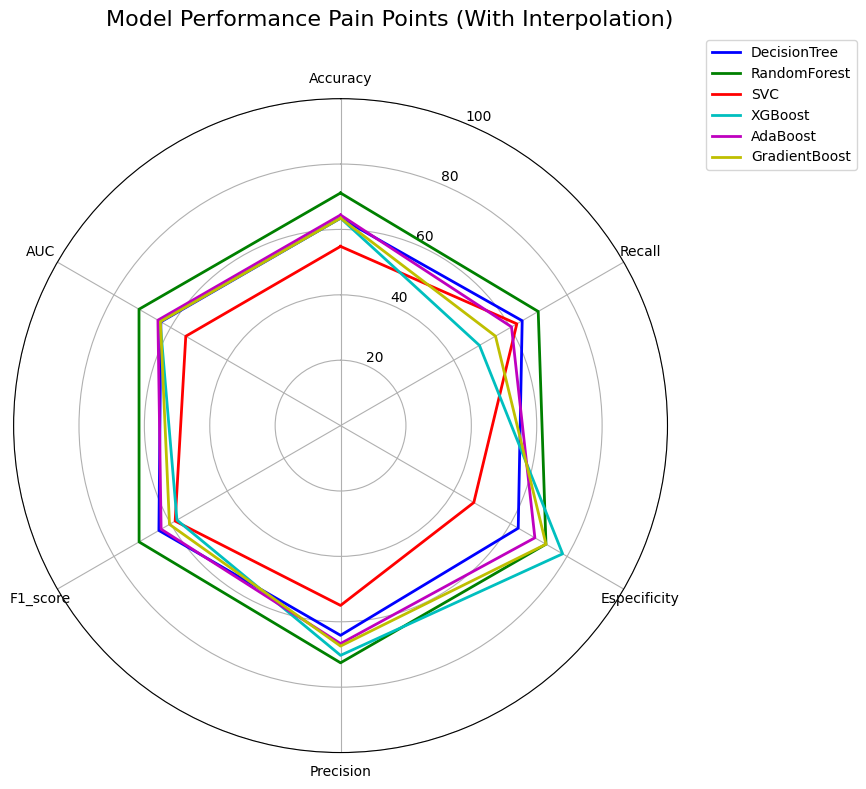

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided
data = {
    "Metric": ["Accuracy", "Recall", "Especificity", "Precision", "F1_score", "AUC"],
    "DecisionTree": [63.46, 64.15, 62.75, 64.15, 64.15, 63.45],
    "RandomForest": [71.15, 69.81, 72.55, 72.55, 71.15, 71.18],
    "SVC": [54.81, 62.26, 47.06, 55.0, 58.41, 54.66],
    "XGBoost": [63.46, 49.06, 78.43, 70.27, 57.78, 63.74],
    "AdaBoost": [64.42, 60.38, 68.63, 66.67, 63.37, 64.5],
    "GradientBoost": [63.46, 54.72, 72.55, 67.44, 60.42, 63.63]
}


# Create DataFrame
df = pd.DataFrame(data)

# Radar Chart Settings
labels = df["Metric"].values
num_vars = len(labels)

# # Angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Colors for each model
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Add each model to the graph
for i, (model, color) in enumerate(zip(df.columns[1:], colors)):
    values = df[model].values.tolist()
    values += values[:1]
    ax.plot(angles, values, label=model, color=color, linewidth=2)
    # ax.fill(angles, values, color=color, alpha=0.1)


# fig.suptitle("Model Performance Comparison (With PAHO Recommendation)", fontsize=16)
fig.suptitle("Model Performance Pain Points (With Interpolation)", fontsize=16)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 100)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()


plt.show()


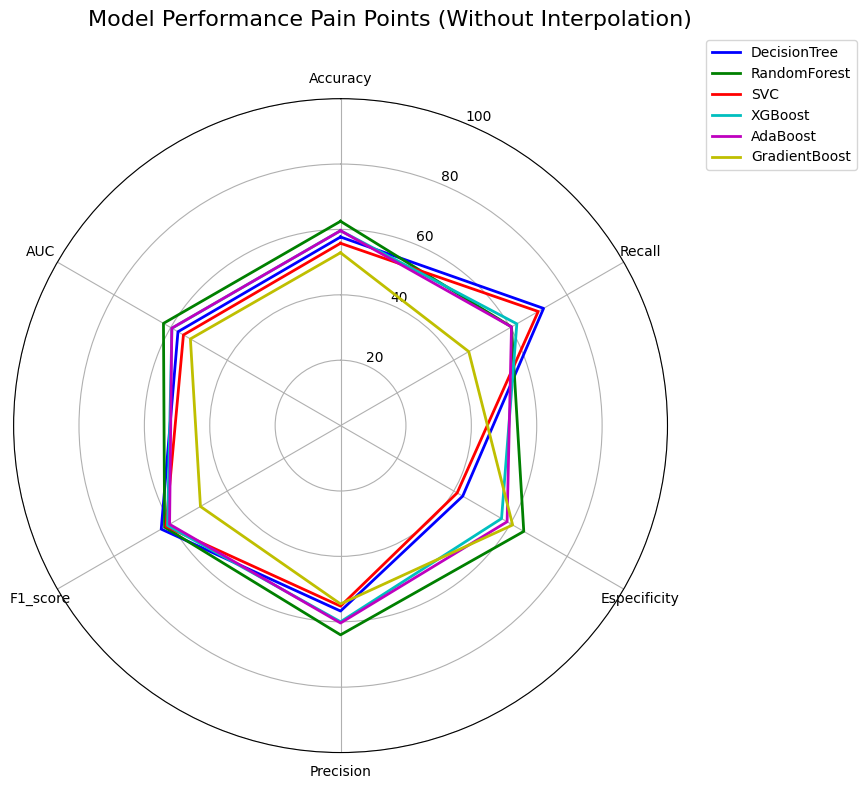

In [ ]:
# New data for the "Without PAHO recommendation" chart
data_without_paho = {
    "Metric": ["Accuracy", "Recall", "Especificity", "Precision", "F1_score", "AUC"],
    "DecisionTree": [57.69, 71.7, 43.14, 56.72, 63.33, 57.42],
    "RandomForest": [62.5, 60.38, 64.71, 64.0, 62.14, 62.54],
    "SVC": [55.77, 69.81, 41.18, 55.22, 61.67, 55.49],
    "XGBoost": [59.62, 62.26, 56.86, 60.0, 61.11, 59.56],
    "AdaBoost": [59.62, 60.38, 58.82, 60.38, 60.38, 59.6],
    "GradientBoost": [52.88, 45.28, 60.78, 54.55, 49.48, 53.03]
}



df2 = pd.DataFrame(data_without_paho)

# Angles for the radar chart
angles2 = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles2 += angles2[:1]


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
# Add each model to the graph
for i, (model, color) in enumerate(zip(df2.columns[1:], colors)):
    values = df2[model].values.tolist()
    values += values[:1]
    ax.plot(angles2, values, label=model, color=color, linewidth=2)
    # ax.fill(angles2, values, color=color, alpha=0.1)


# fig.suptitle("Model Performance Comparison (Without PAHO Recommendation)", fontsize=16)
fig.suptitle("Model Performance Pain Points (Without Interpolation)", fontsize=16)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles2[:-1]), labels)
ax.set_ylim(0, 100)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()

# Mostrar gráfico
plt.show()
